In [1]:
using AutoRisk
using Distributions
using PGFPlots

In [2]:
type BudgetTimer
    budget::Float64 # budget in seconds
    start_time::Float64
    pause_start::Float64
    function BudgetTimer(budget::Float64)
        new(budget, time())
    end
end

function has_time_remaining(timer::BudgetTimer)
    return (time() - timer.start_time) < timer.budget
end

function pause(timer::BudgetTimer)
    timer.pause_start = time()
end

function unpause(timer::BudgetTimer)
    timer.start_time += time() - timer.pause_start
end

function past_fraction(timer::BudgetTimer, fraction::Float64)
    return (time() - timer.start_time) / timer.budget > fraction
end

past_fraction (generic function with 1 method)

In [3]:
function pretty_print(a::Array{Float64})
    if length(size(a)) > 1
        for i in 1:size(a, 2)
            println(a[:,i])
        end
    else
        println(a)
    end
end

pretty_print (generic function with 1 method)

In [4]:
function normalize_log_probs(w::Array{Float64}, axis::Int = 1)
    exp_values = exp(w .- maximum(w, axis))
    probs = exp_values ./ sum(exp_values, axis)
    return probs
end

function get_gmm_dists(mus::Array{Float64}, sigmas::Array{Float64})
    K = size(mus, 2)
    try
        dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
    catch e
        println("exception raised while getting the gmm dists: $(e)")
        for i in 1:K
            println("component $(i)")
            println("mus: $(mus[:,i])")
            println("sigmas: $(sigmas[:,:,i])")
        end
        throw(e)
    end
end

function compute_gmm_ll(samples::Array{Float64}, pis::Array{Float64}, mus::Array{Float64}, 
    sigmas::Array{Float64}, samp_w::Array{Float64} = ones(size(samples, 2)))
    N, K = size(samples, 2), length(pis)
    dists = get_gmm_dists(mus, sigmas)
    ll = 0
    for sidx in 1:N
        total = 0
        for k in 1:K
            total += pis[k] * pdf(dists[k], samples[:, sidx])
        end
        ll += samp_w[sidx] * log(total)
    end
    return ll
end

function fit_gmm(samples::Array{Float64}; samp_w::Array{Float64} = ones(1, size(samples,2)), 
        max_iters::Int = 30, tol::Float64 = 1e-2, num_components::Int = 2)
    # init
    N, K, D = size(samples, 2), num_components, length(samples[:, 1])
    w = zeros(K, N)
    
    mus = zeros(D, K)
    step = Int(ceil(D / K))
    for k in 1:K
        s = (k-1) * step
        e = s + step
        mus[:,k] = mean(samples[:, s+1:e],2)
    end
    
    sigmas = zeros(D, D, K)
    for k in 1:K
        sigmas[:,:,k] = eye(D)
    end
    pis = rand(K)
    pis ./= sum(pis)
    dists = get_gmm_dists(mus, sigmas)
    prev_ll = compute_gmm_ll(samples, pis, mus, sigmas)
    for iteration in 1:max_iters
        # e-step
        log_pis = log(pis)
        for sidx in 1:N
            for k in 1:K
                w[k, sidx] = log_pis[k] + logpdf(dists[k], samples[:, sidx])
            end
        end
        w = normalize_log_probs(w)
        w .*= samp_w # account for sample probability

        # m-step
        pis = sum(w, 2) ./ sum(w)
        
        mus = zeros(D, K)
        for k in 1:K
            for sidx in 1:N
                mus[:, k] += w[k,sidx] * samples[:,sidx]
            end
            mus[:, k] ./= sum(w[k,:])
        end
        
        if any(isnan(mus))
            pretty_print(w)
            readline()
        end
        
        sigmas = ones(D,D,K) * 1e-8
        for k in 1:K
            for sidx in 1:N
                diff = samples[:,sidx] - mus[:, k]
                sigmas[:, :, k] += w[k, sidx] * (diff * transpose(diff))
            end
            sigmas[:, :, k] ./= sum(w[k, :])
        end
        
        # check for convergence
        ll = compute_gmm_ll(samples, pis, mus, sigmas, samp_w)
#         println("iter $(iteration) ll $(ll)")
        if abs(ll - prev_ll) < tol
            break
        else
            prev_ll = ll
            dists = get_gmm_dists(mus, sigmas)
        end
    end
    return pis, mus, sigmas
end

fit_gmm (generic function with 1 method)

pis: [0.159561; 0.201073; 0.639365]
mus: [1.555 2.02101 -1.98404; 1.5467 2.13365 -0.0663582]
sigmas: [0.851188 0.821616; 0.821616 1.07856]

[1.1912 1.00882; 1.00882 0.951838]

[1.13649 -0.443648; -0.443648 5.29447]
pis: [0.483093; 0.516907]
mus: [1.47318 -1.46353]
sigmas: [0.340886]

[0.335934]


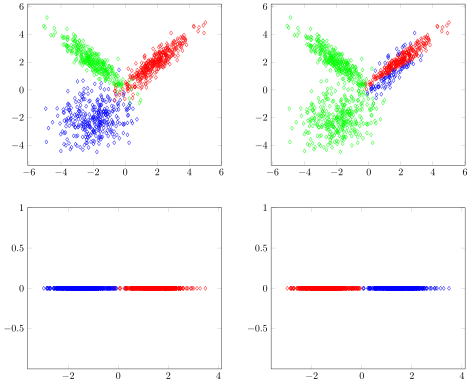

In [5]:
# check the EM implementation
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
sc = "{a={mark=diamond,blue},b={mark=diamond,red},c={mark=diamond,green}}"

# 2d check
num_samples = 1000
samples = zeros(2, num_samples)
gauss1 = MvNormal([-2.,-2.],[[1., 0.] [0., 1.]])
gauss2 = MvNormal([2.,2.],[[1., .9] [.9, 1.]])
gauss3 = MvNormal([-2.,2.],[[1., -.9] [-.9, 1.]])
z = String[]
for i in 1:size(samples, 2)
    v = rand()
    if v < .33
        samples[:, i] = rand(gauss1)
        push!(z, "a")
    elseif v < .66
        samples[:, i] = rand(gauss2)
        push!(z, "b")
    else
        samples[:, i] = rand(gauss3)
        push!(z, "c")
    end
end
scatter_orig = Plots.Scatter(samples[1,:], samples[2,:], z, scatterClasses=sc)
push!(g, scatter_orig)

pis, mus, sigmas = fit_gmm(samples, num_components = 3)
println("pis: $(pis)")
println("mus: $(mus)")
println("sigmas: $(sigmas)")

N, K = size(samples, 2), length(pis)
dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
z = String[]
for sidx in 1:N
    p1 = pis[1] * pdf(dists[1], samples[:, sidx])
    p2 = pis[2] * pdf(dists[2], samples[:, sidx])
    p3 = pis[3] * pdf(dists[3], samples[:, sidx])
    
    if p1 > p2 && p1 > p3
        cur_z = "a"
    elseif p2 > p1 && p2 > p3
        cur_z = "b"
    else
        cur_z = "c"
    end
    push!(z, cur_z)
end
scatter_pred = Plots.Scatter(samples[1,:], samples[2,:], z, scatterClasses=sc)
push!(g, scatter_pred)

# 1d check
samples = zeros(1, num_samples)
gauss1 = Normal(-1.5, .6)
gauss2 = Normal(1.5, .6)
z = String[]
samp_w = Float64[]
for i in 1:size(samples, 2)
    if rand() > .5
        samples[:, i] = rand(gauss1)
        push!(z, "a")
        push!(samp_w, 1.)
    else
        samples[:, i] = rand(gauss2)
        push!(z, "b")
        push!(samp_w, 1.)
    end
end
scatter_orig = Plots.Scatter(samples[1,:], zeros(length(samples[1,:])), z, scatterClasses=sc)
push!(g, scatter_orig)

pis, mus, sigmas = fit_gmm(samples, samp_w = reshape(samp_w, 1, length(samp_w)))
println("pis: $(pis)")
println("mus: $(mus)")
println("sigmas: $(sigmas)")

N, K = size(samples, 2), length(pis)
dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
z = String[]
for sidx in 1:N
    p1 = pis[1] * pdf(dists[1], samples[:, sidx])
    p2 = pis[2] * pdf(dists[2], samples[:, sidx])
    cur_z = p1 > p2 ? "a" : "b"
    push!(z, cur_z)
end
scatter_pred = Plots.Scatter(samples[1,:], zeros(length(samples[1,:])), z, scatterClasses=sc)
push!(g, scatter_pred)

g

In [11]:
# Agent
abstract Agent
@with_kw type GaussianOneDAgent <: Agent
    μ::Float64 = 0.
    σ::Float64 = 1.
end
step(agent::GaussianOneDAgent, state::Array{Float64}) = [randn() * agent.σ + agent.μ]

# Sampler
abstract Sampler

function Distributions.pdf(sampler::Sampler, x::Array{Float64})
    if length(size(x)) > 1
        D, N = size(x)
        w = ones(N)
        for i in 1:N
            w[i] = prod(pdf(sampler.dists[j], x[j, i]) for j in 1:D)
        end
            return w
    else
        return prod(pdf(sampler.dists[i], x[i]) for i in 1:length(x))
    end
end

function sample!(sampler::Sampler, x::Array{Float64}; xmin::Float64=0., xmax::Float64=0.)
    for (i, dist) in enumerate(sampler.dists)
        x[i] = rand(dist) 
    end
end
# base update does nothing
update!(sampler::Sampler, feedback::Dict{Array{Float64},Float64}) = sampler
update!(sampler::Sampler, feedback::Dict{Array{Float64},Float64}, true_sampler::Sampler) = sampler
reset_dists!(sampler::Sampler, dists::Any) = sampler

# basic sampler
type BasicSampler <: Sampler
    dists::Vector{Distribution}
end

type CEMSampler <: Sampler
    dists::Any
    update_dists_every::Int
    feedback::Dict{Array{Float64},Float64}
    num_components::Int
    cur_idx::Int
    function CEMSampler(dists::Any; update_dists_every::Int = 100, num_components::Int = 2)
        return new(dists, update_dists_every, Dict{Array{Float64},Float64}(), num_components, 0)
    end
end
        
function softmax(values::Array{Float64})
    exp_values = exp(values .- maximum(values))
    probs = exp_values ./ sum(exp_values)
    return probs
end

# update stats associated with the most recent sample
        function update_dists!(sampler::CEMSampler, true_w::Array{Float64}, samples::Array{Float64}, td_errors::Array{Float64})

    utility_weights = softmax(abs(td_errors))
    true_w = true_w .* utility_weights
            
    for (i, dist) in enumerate(sampler.dists)
        proposal_w = pdf(dist, reshape(samples[i,:], 1, length(samples[i,:])))
        samp_w = true_w ./ proposal_w
        samp_w = reshape(samp_w, 1, length(samp_w))
        pis, mus, sigmas = fit_gmm(samples, samp_w = samp_w, num_components = sampler.num_components)
                
        normals = MvNormal[MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:length(pis)]
        sampler.dists[i] = MixtureModel(normals, reshape(pis, length(pis)))
    end
end
        
function update!(src::Dict{Array{Float64},Float64}, dest::Dict{Array{Float64},Float64})
    for (k,v) in src
        dest[k] = v
    end
end

function update!(sampler::CEMSampler, feedback::Dict{Array{Float64},Float64}, true_sampler::Sampler)
    update!(feedback, sampler.feedback)
    if sampler.cur_idx == sampler.update_dists_every
        sampler.cur_idx = 0
        samples = hcat(keys(sampler.feedback)...)
        true_w = pdf(true_sampler, samples)
        num_samples = size(samples, 2)
        td_errors = zeros(Float64, num_samples)
        for i in 1:num_samples
            td_errors[i] = feedback[samples[:,i]]
        end
        update_dists!(sampler, true_w, samples, td_errors)
    end
end
function sample!(sampler::CEMSampler, x::Array{Float64}; xmin::Float64=-1., xmax::Float64=1.)
    sampler.cur_idx += 1
    for (i, dist) in enumerate(sampler.dists)
        x[i] = rand(dist)[1]
        x[i] = min(max(env.x[i], env.xmin), xmax)
    end
    return x
end

function reset_dists!(sampler::CEMSampler, dists::Any)
    sampler.dists = copy(dists)
    sampler.cur_idx = 0
end

# env
abstract Env
@with_kw type OneDEnv <: Env
    xmin::Float64 = -10.
    xmax::Float64 = 10
    x::Array{Float64} = [0.]
    true_sampler::Sampler = BasicSampler([Uniform(xmin, xmax)])
    sampler::Sampler = BasicSampler([Uniform(xmin, xmax)])
end
function reset(env::OneDEnv) 
            sample!(env.sampler, env.x, xmin=env.xmin, xmax=env.xmax)
    env.x
end
function reset(env::OneDEnv, x::Array{Float64})
    env.x = x
end
function update!(env::OneDEnv, feedback::Dict{Array{Float64},Float64})
    update!(env.sampler, feedback, env.true_sampler)
end
function step(env::OneDEnv, a::Array{Float64})
    env.x += a[1]
    if env.x[1] > env.xmax
        r = 1.
        done = true
    elseif env.x[1] < env.xmin
        r = 0.
        done = true
    else
        r = 0.
        done = false
    end
    return (env.x, r, done)
end

step (generic function with 2 methods)

In [12]:
# budget, env, agent, learner, t_max, mc_runs, discount 
function fit(learner::PredictionModel, env::Env, agent::Agent; 
            budget::Float64 = 5., t_max::Int = 10, mc_runs::Int = 1, discount::Float64 = 1., 
        states::Array{Float64} = zeros(1), true_v = nothing, ncurve_pts::Int = 10)
    timer = BudgetTimer(budget)
    curve = Float64[]
    curve_pt = .6
    while has_time_remaining(timer)
        
        # collect data
        init_x = reset(env)
        x = copy(init_x)
        for run in 1:mc_runs
            copy!(x, init_x)
            reset(env, x)
            t, done = 0, false
            while t < t_max && !done
                a = step(agent, x)
                nx, r, done = step(env, a)
                learner_done = AutoRisk.step(learner, x, a, [r], nx, done)
                done = done || learner_done
                x = nx
                t += 1
            end
        end
        
        # feedback
        feedback = AutoRisk.get_feedback(learner)
        update!(env, feedback)
        
        # track progress if ground truth available
        if !(true_v == nothing) && past_fraction(timer, curve_pt / ncurve_pts)
            pause(timer)
            pred_v = predict(learner, states)
            push!(curve, mean(sqrt((true_v - pred_v).^2)))
            curve_pt += 1.
            unpause(timer)
        end
    end
    learner, curve
end

fit (generic function with 1 method)

In [13]:
# env
xmin, xmax = -100000, 100000
discount = .9
num_eval_steps = 1000 # number of steps at which to evaluate learned policy
use_prioritized_sampling = true
sigma = (xmax - xmin) / 2.
orig_dists = [MixtureModel(
        MvNormal[
        MvNormal([xmin / 2.], [sigma]), 
            MvNormal([xmax / 2.], [sigma]),
        ], 
        [0.49, 0.51])]
# orig_dists = [MixtureModel(
#         MvNormal[
#             MvNormal([xmin / 2.], [sigma]), 
#             MvNormal([0], [sigma]),
#             MvNormal([xmax / 2.], [sigma]),
#         ], 
#         [0.33, 0.34, 0.33])]
# orig_dists = [MixtureModel(MvNormal[MvNormal([0.], [sigma * 2])], [1.0])]
if use_prioritized_sampling
    sampler = CEMSampler(orig_dists, update_dists_every = 10, num_components = 2)
    env = OneDEnv(xmin = xmin, xmax = xmax, sampler = sampler)
else
    env = OneDEnv(xmin = xmin, xmax = xmax)
end

# agent 
agent = GaussianOneDAgent(σ = 1.);

# learner 
nbins = 40
bins = linspace(env.xmin, env.xmax, nbins)
grid = RectangleGrid(bins)
target_dim = 1
learner = TDPredictor(grid, target_dim);

In [14]:
function AutoRisk.step(predictor::TDPredictor, x::Array{Float64}, a::Array{Float64}, 
        r::Array{Float64}, nx::Array{Float64}, done::Bool)

    # update 
    total_td_error = 0
    inds, ws = interpolants(predictor.grid, x)
    for (ind, w) in zip(inds, ws)
        # target value
        target = r
        if !done
            target += predictor.discount * predict(predictor, x)
        end
        
        if ind == 0
            continue
        end

        # update
        td_error = w * (target - predict(predictor, nx))
        predictor.values[:, ind] += predictor.lr * td_error
        total_td_error += td_error
    end

    # store td-error associated with this state for later use as feedback
    predictor.td_errors[x] = sum(abs(total_td_error))
end

In [15]:
# get the true values
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
if discount == 1.
    m = 1. / (xmax - xmin)
    b = xmin
    true_v = reshape(linspace(xmin, xmax, num_eval_steps), 1, 1000) .* m .+ .5
else
    reset!(learner)
    reset_dists!(env.sampler, orig_dists)
    fit(learner, env, agent, budget = 10., t_max = 1, mc_runs = 1, discount = discount);
    true_v = predict(learner, states)
    println(env.sampler.dists)
end
println(size(true_v))
a = Axis(legendPos="south west", width="8cm", height="8cm", xlabel="Position (m)", ylabel="Pr(exit right)", 
title ="State Values of Motivating Example")
myplot = Plots.Linear(states[1,:], true_v[1,:])
push!(a, myplot)
PGFPlots.save("/Users/wulfebw/Desktop/value.pdf", a)
a

LoadError: KeyError: key [26936.5] not found

In [ ]:
# compare different values
num_runs = 2 # number of times each run is executed
ncurve_pts = 30
budget = 30. # number of seconds for which it is executed
t_max_nbins, t_max_min, t_max_max = 2, 1, 100
t_max_list = linspace(t_max_min, t_max_max, t_max_nbins)
t_max_list = map(x -> Int(ceil(x)), t_max_list)
mc_nbins, mc_min, mc_max = 2, 1, 30
mc_runs_list = linspace(mc_min, mc_max, mc_nbins)
mc_runs_list = map(x -> Int(ceil(x)), mc_runs_list)
results = zeros(t_max_nbins, mc_nbins)
vs = zeros(num_eval_steps, t_max_nbins, mc_nbins)
curves = zeros(ncurve_pts, num_runs, t_max_nbins, mc_nbins)
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
best_dists = Dict()
for (i, t_max) in enumerate(t_max_list)
    for (j, mc_runs) in enumerate(mc_runs_list)
        best_loss = Inf
        best_dist = nothing
        for run in 1:num_runs
            # fit
            reset!(learner)
            reset_dists!(env.sampler, orig_dists)
            _, curve = fit(learner, env, agent, budget = budget, t_max = t_max, mc_runs = mc_runs, 
            states = states, true_v = true_v, ncurve_pts = ncurve_pts, discount = discount);
            v = predict(learner, states)
            
            # track results
            loss = sum(abs(true_v - v))
            results[i, j] += loss
            curves[:,run,i,j] = curve
            if loss < best_loss
                best_dists[(i,j)] = copy(env.sampler.dists)
                vs[:, i, j] = v
                best_loss = loss
            end
        end
        results[i,j] /= num_runs
    end
end

In [ ]:
# plot the average learning curves
g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 1.5cm, vertical sep = 1.4cm")
a = Axis(legendPos="south west", width="16cm", height="16cm", xlabel="Seconds", ylabel="Root Mean Square Error", 
title="Error in Estimated Risk", ymin=0., ymax=.6)
markcolors = ["red", "blue", "green", "black"]
markers = ["square", "triangle", "o", "diamond"]
for (i, t_max) in enumerate(t_max_list)
    markcolor = markcolors[i]
    for (j, mc_runs) in enumerate(mc_runs_list)
        marker = markers[j]
        avg_curve = mean(curves[:,:,i,j], 2)
        p = Plots.Linear(1:length(avg_curve), avg_curve[:,1], 
        legendentry="steps: $(t_max) monte carlo runs: $(mc_runs)",
        mark="$(marker)",
        style="$(markcolor),thick",
        markSize=4)
        push!(a, p)
    end
end
PGFPlots.save("/Users/wulfebw/Desktop/sampling.pdf", a)
a

In [ ]:
# plot all the value functions
g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 2cm, vertical sep = 2cm")
states = reshape(collect(linspace(env.xmin, env.xmax, num_eval_steps)), 1, num_eval_steps)
for (i, t_max) in enumerate(t_max_list)
    for (j, mc_runs) in enumerate(mc_runs_list)
        p = Axis(Plots.Linear(states[1,:], vs[:,i,j], legendentry="error: $(round(results[i,j],3))"), 
            width="5.5cm", 
            height="5.5cm",
        legendPos="north west",
        title=string("steps: $(t_max) monte carlo runs: $(mc_runs)"))
        push!(g, p)
    end
end
g

In [ ]:
# heatmap the results
println(results)
function get_results_heat(x, y)
    return results[Int(floor(x)), Int(floor(y))]
end

xbins = length(t_max_list)
ybins = length(mc_runs_list)
img = Axis(Plots.Image(get_results_heat, (1, xbins), (1, ybins), xbins=xbins, ybins=ybins), 
        width="16cm", 
        height="16cm",
        xlabel="t max",
        ylabel="mc runs")


In [ ]:
# visualize the sampling distributions at the end if applicable
g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 1.5cm, vertical sep = 1.4cm")
if use_prioritized_sampling
    num_samples = 5000
    samples = zeros(num_samples, mc_nbins, t_max_nbins)
    for (i, t_max) in enumerate(t_max_list)
        for (j, mc_runs) in enumerate(mc_runs_list)
            dist = best_dists[(i,j)][1]
            samples[:, j, i] = rand(dist, num_samples)
            a = Axis(Plots.Histogram(samples[:,j,i], bins=50), 
                xmin=env.xmin, 
                xmax=env.xmax, 
                width="5.5cm", 
                height="5.5cm",
                legendPos="north west",
                title=string("t-max: $(t_max) mc: $(mc_runs)"))
            push!(g, a)
        end
    end
end
g